<a href="https://colab.research.google.com/github/dscho15/deep-learning/blob/main/Lecture8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from tqdm.notebook import tqdm
from scipy import ndimage
from google_drive_downloader import GoogleDriveDownloader as gdd

# Online resources used:

https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

In [2]:
gdd.download_file_from_google_drive('1Uzgc9c0MSYP4y9ia7mvwCGggjhTDEmrk', '~/img_align_celeba_50k.npz')
blob = np.load('~/img_align_celeba_50k.npz')
x_train, x_test = blob['x_train'], blob['x_test']
dim = x_train.shape[1:]
n_valid = 2000
x_train, x_valid = x_train[:-n_valid], x_train[-n_valid:]

print(f'x_train shape: {x_train.shape}')
print(f'x_valid shape: {x_valid.shape}')
print(f'dtype: {x_train.dtype}')

x_train shape: (48000, 32, 32, 3)
x_valid shape: (2000, 32, 32, 3)
dtype: float32


In [3]:
x_train_blur = np.empty_like(x_train)
for i in tqdm(range(len(x_train))):
    # apply your noise model here
    x_train_blur[i] = cv2.GaussianBlur(x_train[i], (3, 3), cv2.BORDER_DEFAULT)
    x_train_blur[i] = x_train_blur[i]

x_valid_blur = np.empty_like(x_valid)
for i in tqdm(range(len(x_valid))):
    # apply your noise model here
    x_valid_blur[i] = cv2.GaussianBlur(x_valid[i], (3, 3), cv2.BORDER_DEFAULT)
    x_valid_blur[i] = x_valid_blur[i]

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [4]:
def plot_rows(*img_rows, scale=1.):
    rows = len(img_rows)
    cols = len(img_rows[0])
    fig, axs = plt.subplots(rows, cols, figsize=(cols * scale, rows * scale))
    for i, img_row in enumerate(img_rows):
        for j, im in enumerate(img_row):
            ax = axs[i, j]
            ax.imshow(np.clip(im, 0, 1))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

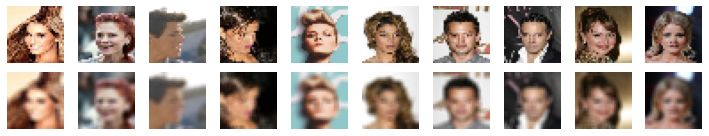

In [5]:
plot_rows(x_train[:10], x_train_blur[:10])

In [6]:
mu, std = np.mean(x_train, axis=(0, 1, 2)), np.std(x_train, axis=(0, 1, 2))
print("mu: ", mu, " sigma: ", std)

def norm(a):
    return torch.from_numpy((a - mu) / std).permute(0, 3, 1, 2)

def denorm(a):
    return a.detach().cpu().permute(0, 2, 3, 1).numpy() * std + mu

x_train_normed = norm(x_train)
x_valid_normed = norm(x_valid)
x_train_blur_normed = norm(x_train_blur)
x_valid_blur_normed = norm(x_valid_blur)

mu:  [0.34133333 0.34133333 0.34133333]  sigma:  [0.32654327 0.27426648 0.2628333 ]


In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self, input_channels, kernel_size):

      super(AutoEncoder, self).__init__()

      self.encoder = model = nn.Sequential(
                                            nn.Conv2d(input_channels, 16, kernel_size, stride = 2, padding = 1),
                                            nn.ReLU(inplace=True),

                                            nn.Conv2d(16, 32, kernel_size, stride = 1, padding = 1),
                                            nn.ReLU(inplace=True),
                                            nn.BatchNorm2d(32),
                                            # nn.MaxPool2d(2, (2, 2)),
                                            
                                            nn.Conv2d(32, 64, kernel_size, stride = 1, padding = 1),
                                            nn.ReLU(inplace=True),
                                            # nn.MaxPool2d(2, (2, 2))
                                        )


      self.decoder = model = nn.Sequential(
                                            nn.ConvTranspose2d(64, 32, kernel_size, stride = 1, padding = 1, output_padding = 0),
                                            nn.ReLU(inplace=True),
                                            
                                            nn.ConvTranspose2d(32, 16, kernel_size, stride = 1, padding = 1, output_padding = 0),
                                            nn.ReLU(inplace=True),
                                            
                                            nn.ConvTranspose2d(16, input_channels, kernel_size, stride = 2, padding = 1, output_padding = 1)
                                        )

    def forward(self, x):
        h = self.encoder(x)
        y = self.decoder(h)
        return y, h
    
    def reparameterize(self, mu, log_var):
      

ae = AutoEncoder(3, 3)
print(ae( train_data[0][0].reshape((1, 3, 32, 32)) )[0].shape)


# complete this function and return the model
def build_model():  
  return AutoEncoder(3, 3)
    
    

torch.Size([1, 3, 32, 32])


In [ ]:
train_data = list(zip(x_train_blur_normed, x_train_normed))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)

valid_data = list(zip(x_valid_blur_normed, x_valid_normed))
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0, mse loss (train/valid): 0.1295/0.0726
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


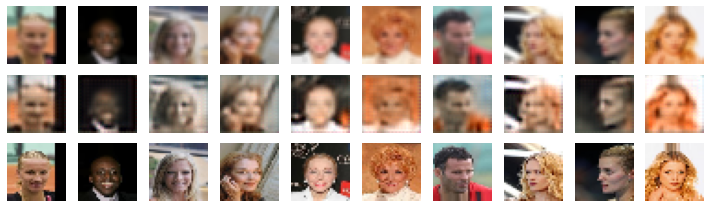

epoch: 1, mse loss (train/valid): 0.0654/0.0654
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


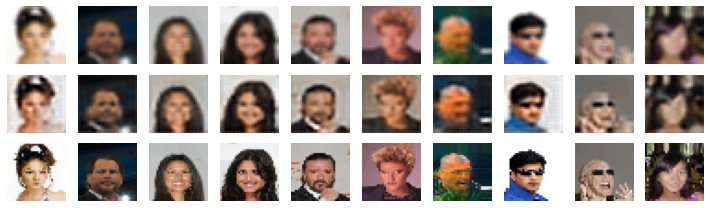

epoch: 2, mse loss (train/valid): 0.0557/0.0518
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


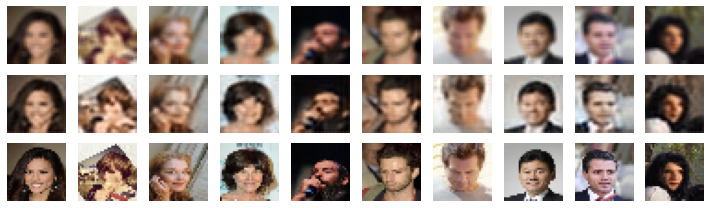

epoch: 3, mse loss (train/valid): 0.0485/0.0443
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


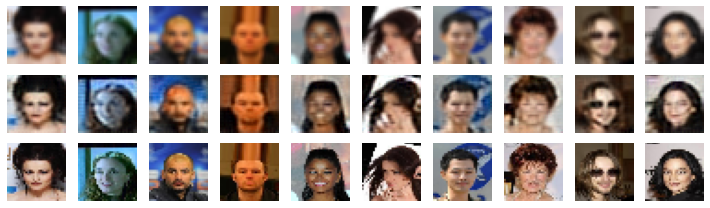

epoch: 4, mse loss (train/valid): 0.0422/0.0397
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


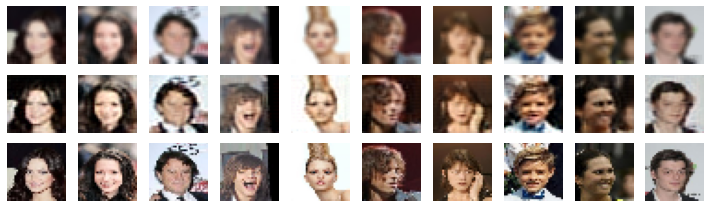

epoch: 5, mse loss (train/valid): 0.0367/0.0349
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


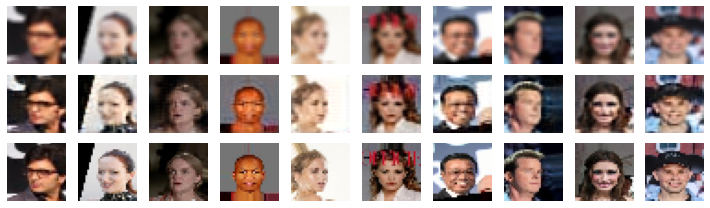

epoch: 6, mse loss (train/valid): 0.0332/0.0331
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


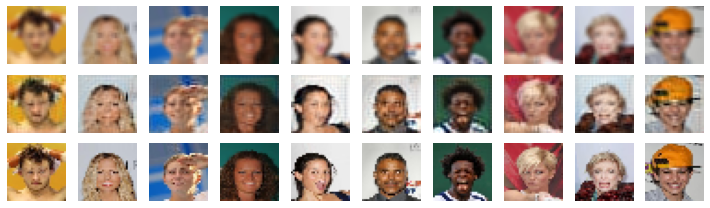

epoch: 7, mse loss (train/valid): 0.0309/0.0288
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


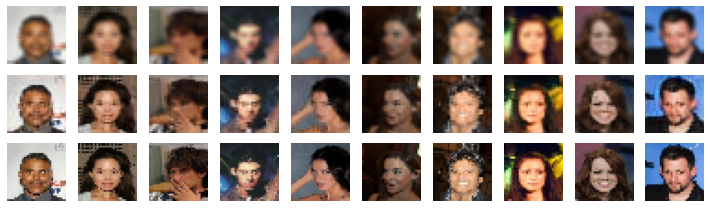

epoch: 8, mse loss (train/valid): 0.0286/0.0277
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


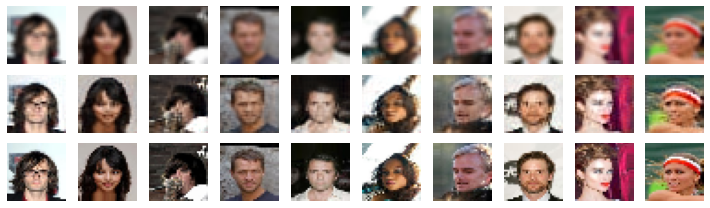

epoch: 9, mse loss (train/valid): 0.0272/0.0272
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


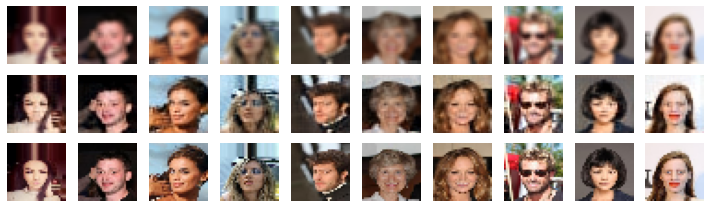

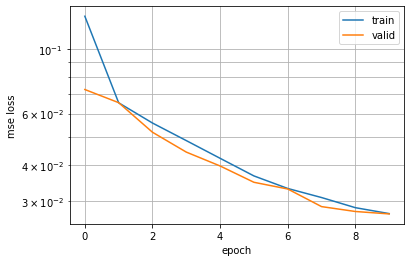

In [ ]:
model = build_model().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
valid_losses = []

for epoch in tqdm(range(10)):
    losses = []
    for x, y in train_dataloader:
        x, y = x.cuda(), y.cuda()
        y_hat, h = model(x)
        loss = F.huber_loss(y_hat, y) + F.l1_loss(h, torch.zeros_like(h).cuda())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    train_losses.append(np.mean(losses))

    losses = []
    for x, y in valid_dataloader:
        x, y = x.cuda(), y.cuda()
        y_hat, h = model(x)
        loss = F.huber_loss(y_hat, y) + F.l1_loss(h, torch.zeros_like(h).cuda())
        losses.append(loss.item())
    valid_losses.append(np.mean(losses))

    print(f'epoch: {epoch}, mse loss (train/valid): {train_losses[-1]:.4f}/{valid_losses[-1]:.4f}')
    print('Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)')
    plot_rows(denorm(x[:10]), denorm(y_hat[:10]), denorm(y[:10]), scale=1)

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.grid(which='both')
plt.legend()
plt.show()

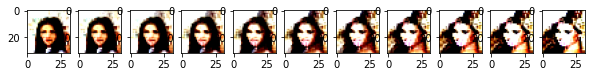

In [ ]:
# Interpolate in Latent Space
img1 = train_data[0][0].reshape((1, 3, 32, 32)).cuda()
img2 = train_data[25][0].reshape((1, 3, 32, 32)).cuda()

# Encode those
latent1 = model.encoder(img1)
latent2 = model.encoder(img2)

plt.figure(2, figsize=(10, 10))
for i in range(10+1):
  plt.subplot(1, 11, i+1)
  latent = latent1 * i/10 + latent2 * (1-i/10)
  interp = model.decoder(latent).cpu().detach().numpy()
  interp = interp.reshape((3, 32, 32)).transpose(1, 2, 0)
  plt.imshow(np.clip(interp, 0, 1))
plt.show()

